![sslogo](https://github.com/stratascratch/stratascratch.github.io/raw/master/assets/sslogo.jpg)

# From Excel to Pandas

In [1]:
# xlrd is needed to load excel files
!pip install xlrd
!pip install psycopg2

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import psycopg2 as ps

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Loading data from files

### Loading from XLSX (Excel format)

We will now load a file stored in excel format with 3 sheets called [iris.xlsx](https://github.com/stratascratch/stratascratch.github.io/raw/master/assets/iris.xlsx).

These 3 sheets represent the 3 varities of iris flowers as studied by [Fisher](https://en.wikipedia.org/wiki/Iris_flower_data_set).

To load from excel we need to use `pd.read_excel`
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html

The main parameters are:
- Filepath which tells it where to find the excel file
- Sheet name which is very versatile and can be a string, integer or a list of strings and integers. If it is a string it means take a single sheet named with that string. If it is a number it means take a sheet by that number.

The dataset intentionally misses headers because we will add them manually and this entails two more parameters which you might need to use often (which are b.t.w. also aplicable to `pd.read_csv`):
- header which can be None or a number. If it is a number it means that the row at that number is the header and everything before that number is skiped.
- names is a list of strings which are column names

In [3]:
# One way to load the data
column_names = ["sepal_length", "sepal_width" , "petal_length", "petal_width", "variety"]

iris_excel_path = "https://github.com/stratascratch/stratascratch.github.io/raw/master/assets/iris.xlsx"

setosa_data = pd.read_excel(iris_excel_path, "Setosa", header=None, names=column_names) # Setosa is the sheet name
versi_data  = pd.read_excel(iris_excel_path, 1, header=None, names=column_names) # 1 is the index of the second sheet
virgi_data  = pd.read_excel(iris_excel_path, 2, header=None, names=column_names)

# we need to reset the index to have nice linear indices from 0, 1 to 150
# reset_index() adds a new column called "index" which we drop (explained later)
iris = pd.concat([setosa_data, versi_data, virgi_data]).reset_index().drop("index", axis=1)

iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# Another way to load the data using one call to pd.read_excel
# We get a dictionary which we can convert to one data frame using pd.concat again
sheets = ["Setosa", "Versicolor", "Virginica"]

column_names = ["sepal_length", "sepal_width" , "petal_length", "petal_width", "variety"]

data_frames_dictionary = pd.read_excel(iris_excel_path, sheets, header=None, names=column_names)

# values() gives us a list of dataframes
data_frames = data_frames_dictionary.values()

# we need to reset the index to have nice linear indices from 0, 1 to 150
iris = pd.concat(data_frames).reset_index().drop("index", axis=1)

#keys are the sheet names
print(data_frames_dictionary.keys())

iris.describe()

odict_keys(['Setosa', 'Versicolor', 'Virginica'])


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
data_frames_dictionary

OrderedDict([('Setosa',
                  sepal_length  sepal_width  petal_length  petal_width variety
              0            5.1          3.5           1.4          0.2  Setosa
              1            4.9          3.0           1.4          0.2  Setosa
              2            4.7          3.2           1.3          0.2  Setosa
              3            4.6          3.1           1.5          0.2  Setosa
              4            5.0          3.6           1.4          0.2  Setosa
              5            5.4          3.9           1.7          0.4  Setosa
              6            4.6          3.4           1.4          0.3  Setosa
              7            5.0          3.4           1.5          0.2  Setosa
              8            4.4          2.9           1.4          0.2  Setosa
              9            4.9          3.1           1.5          0.1  Setosa
              10           5.4          3.7           1.5          0.2  Setosa
              11           4

## The iris dataset from database

This dataset is also present in the database under `datasets.iris`

In [8]:
# Connect to database
host_name = 'db-strata.stratascratch.com'
dbname = 'db_strata'
port = '5432'
user_name = 'ankit082006' #enter username
pwd = 'ofkMQPktC' #enter your database password found in the profile tab in Strata Scratch

try:
    conn = ps.connect(host=host_name,database=dbname,user=user_name,password=pwd,port=port)
except ps.OperationalError as e:
    raise e
else:
    print('Connected!')

def get_dataset(dataset_name):
    #Write SQL below to pull datasets 
    cur = conn.cursor()
    cur.execute(""" 
                SELECT *  FROM {0}; 
                """.format(dataset_name))
    data = cur.fetchall()
    colnames = [desc[0] for desc in cur.description] 
    conn.commit()

    #create the pandas dataframe
    dataframe = pd.DataFrame(data, columns=colnames)

    #close the connection
    cur.close()
    
    return dataframe

Connected!


In [9]:
# We load iris and by the way we also load four more datasets that we'll use later
iris = get_dataset("iris")

nominee_filmography = get_dataset("nominee_filmography")
nominee_information = get_dataset("nominee_information")
billboard_top_100 = get_dataset("billboard_top_100_year_end")

sat_scores = get_dataset("sat_scores")

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## Saving data to files

Each dataframe has two methods called `to_csv` and `to_excel` whose documentation can be found at:
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html

## Simple math in pandas

You can add together two columns to get an elementwise addition.

In [10]:
(iris["petal_width"] + iris["sepal_width"]).head()

0    3.7
1    3.2
2    3.4
3    3.3
4    3.8
dtype: float64

Other operations are also supported (multiplication (`*`), substraction(`-`) and division(`/`)) 

In [11]:
# Get rectangular approximation of petal area using elementwise multiplication
(iris["petal_length"] * iris["petal_width"]).head()

0    0.28
1    0.28
2    0.26
3    0.30
4    0.28
dtype: float64

You can also apply operations and scalars.

For example you can add a scalar to a column and you can multiply by a scalar.

What happens in the background is that the scalar gets replicated into an ndarray which is then processed as described above depending on the operator.

In [12]:
(5 * iris["sepal_length"] + 10).head()

0    35.5
1    34.5
2    33.5
3    33.0
4    35.0
Name: sepal_length, dtype: float64

#### Replicating scalars to array in python.

In excel you can write a value in cell and then you drag down with your mouse and the value replicates itself to cells below.

In python we have a special syntax for this.
- `items * amount` where items is a python list (not ndarray) and amount is an integer.

In [13]:
["plenty"] * 10

['plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty',
 'plenty']

In [14]:
[5] * 10

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [15]:
5 * 10

50

In [16]:
np.array(["few"] * 3)

array(['few', 'few', 'few'], dtype='<U3')

#### Linear sequences in python

In Excel if you hold shift and drag down the value of the cell will get copied downwards while the value linearly increases by 1.

To get the same effect in python we use `np.arange`.

In [17]:
np.arange(7, 32)

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31])

## Column operations

### Dropping columns

You can permanently get rid of some columns you no longer need in your dataframe with a call to `pd.DataFrame.drop`:
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

By default this method drops rows but if you pass `axis=1` it will drop columns.

The main parameter (besides axis) is the `labels` which is a list of columns names you wish to drop.

By default this method returns a new dataframe with the dropped column unless you also pass `inplace=True` in which case it modifies the dataframe in place and returns None. 

In [18]:
# Droping the petal columns

iris_without_petals = iris.drop(labels=["petal_width", "petal_length"], 
                                axis=1, 
                                inplace=False)

iris_without_petals.head()

,sepal_length,sepal_width,variety
0,5.1,3.5,Setosa
1,4.9,3.0,Setosa
2,4.7,3.2,Setosa
3,4.6,3.1,Setosa
4,5.0,3.6,Setosa


### Reordering columns

Due to the implementation nature of pandas reordering columns is actually not a straight forward thing to do.

To do that you need to construct a new dataframe using a dictionary and ordering the columns as you wish in it.

Here in this example we will put variety first and swap the places of sepals and petals.

In [0]:
iris_reorder = pd.DataFrame({
    "variety": iris["variety"],
    "petal_length": iris["petal_length"],
    "petal_width": iris["petal_width"],
    "sepal_length": iris["sepal_length"],
    "sepal_width": iris["sepal_width"]
})

iris_reorder.head()

#### Another way to reorder columns

This is the shorter way which is easier to write as a one-liner but it can get clumsy when there are many columns.

The idea is to use the usual column selection via `iris[[...]]` but instead of only a subset we list all columns, in the order we want in the new dataframe, and then we copy to get a new dataframe.

In [0]:
iris[["variety", "petal_length", "petal_width", "sepal_length", "sepal_width"]].copy().head()

### Renaming columns

Sometimes you get columns with ugly and weird names and to save yourself of some typing you might want to rename them and this is where (surprise, surprise) comes the `pd.DataFrame.rename` method:
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html

The primary argument is called mapper and is a dictionary of old names to new names.

By default it also targets rows (the index column to be precise) but if we use `axis=1` it works on column names. 

It also follows the `inplace` contract many other methods do in the same way.

For example our column names are long to write so we can replace them with aliases.

One common use case for rename is changing column names before joins.

In [19]:
iris.rename({
    # old name     new name 
    "sepal_width": "sw",
    "sepal_length": "sl",
    "petal_width": "pw",
    "petal_length": "pl"
}, axis=1).head()

,sl,sw,pl,pw,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


### Filtering columns

Pandas dataframes have one really nifty and powerful method called `pd.DataFrame.filter` 
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.filter.html

Depending on the axis paramater it can be applied to both rows and columns and by default is applied to rows but by now you know the drill `axis=1` is columns.

It has 3 paramaters called `items`, `like` and `regex` of which *only one* must be passed
- items is a list of labels you want returned 
- like is a string which must be contained in column names to be returned
- regex is a supercharged `like` with regular expressions

For example to take only the petals we can use.

In [20]:
iris.filter(like="petal", axis=1).head()

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


## Conditional formating

* https://pandas.pydata.org/pandas-docs/stable/style.html

Each dataframe has a property called `style` and inside that `style` there are two methods:
- `applymap` which allows conditional formating by element
- `apply` which allows conditional formating by rows or columns

To have styling we must use CSS. That means that our styling functions must return strings of special form.
Through examples we will develop what that means.

### Color elements by type

Here we check the type of each element of the dataframe and change its background color based on it.

The syntax `background-color: blue` is called cascading style sheets or [CSS](https://www.w3schools.com/Css/). It always goes `property_name : property_value`. Other examples are `font-size: 16px`, `color: orange`, `font-weight: bold` etc.

Notice that because we operate on elements we always return a single string describing the style.

In [0]:
def color_elements(val):
    """
    If val is string we color it blue.
    If it is a number we color it green.
    """
    
    if type(val) == str:
        return 'background-color: blue'
    else:
        return 'background-color: green'
    
iris.style.applymap(color_elements)

### Highlight the minimum value in each column

Now we will use the `iris.style.apply` method which expects a function that returns a list of styles, one for element in the series.

The meaning of axis here is:
- `axis=0` work on columns
- `axis=1` work on rows
- `axis=None` work on the whole dataframe

In [0]:
def higlight_min(series):
    n_elements = series.shape[0]
    
    # create an array with empty styles which are default for all items
    styles = ['' for i in range(0, n_elements)]
    
    # now set the style for max position to be a orange highlight
    styles[series.idxmin()] = 'background-color: orange'
    
    # finally return the list of styles
    return styles

# We can't use highlight min on the variety column so we drop it 
iris.drop(['variety'], axis=1).style.apply(higlight_min)

### Make the maximum of a row italic

In [0]:
def bold_max(series):    
    n_elements = series.shape[0]
    
    # create an array with empty styles which are default for all items
    styles = ['' for i in range(0, n_elements)]
    
    # now set the style for max position to be a orange highlight
    styles[series.values.argmax()] = 'font-style: italic'
    
    # finally return the list of styles
    return styles

iris.drop(['variety'], axis=1).style.apply(bold_max, axis=1)

This visualizations made it easier for us to see that sepal length is almost always the largest number.

### Change the number format

The style property also allows changing the format using the property of the same name.

It takes a dictionary mapping between column names and formats.

The formating language can be explored farther in:
- https://docs.python.org/3.7/library/string.html#format-string-syntax

For example we will add trailing zeros to our numbers.

In [0]:
iris.style.format({ "sepal_length": "{:.3f}", 
                    "sepal_width": "{:.5f}",
                    "petal_width": "{:.5f}",
                    "petal_length": "{:.3f}"
                  })

### Barcharts in cells

One cool example of styling in pandas is drawing barcharts in cells.
- https://pandas.pydata.org/pandas-docs/stable/style.html#Bar-charts

In our example we also see the first use of the `subset` parameter which is very handy to apply styling selectively and which can also be used in `apply` (rember we used drop but you can get the same effect using subset and writing out all columns except variety in the subset list). 

In [0]:
iris.style.bar(subset=["sepal_length", "petal_length"], color="cyan")

## Filtering data

You have already learned the basics of filtering using comparisons and masks so this section will be about bit more advanced topics. 

The functions covered are:
- `isin` which tests each item of a series for membership in some list
- `query` which filters the dataframes based on expressions

### IsIn example

- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html

In [0]:
iris[iris.variety.isin(["Setosa", "Virginica"])]

### Query

This is a really powerful mechanism for filtering your data but be careful because the error messages tend to be hard to understand.

- http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html

The syntax is best explained through a few examples but it's worth noting that you can access variables using the @ notation.

Sadly it does not support column names which have dots in them so to use `query` we must rename our columns.

#### Example 1 

Find all flowers whose sepal width is below the mean sepal width.

In [21]:
mean_sw = iris["sepal_width"].mean()

iris.query("sepal_width < @mean_sw").head(15)

,sepal_length,sepal_width,petal_length,petal_width,variety
1,4.9,3.0,1.4,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
12,4.8,3.0,1.4,0.1,Setosa
13,4.3,3.0,1.1,0.1,Setosa
25,5.0,3.0,1.6,0.2,Setosa
38,4.4,3.0,1.3,0.2,Setosa
41,4.5,2.3,1.3,0.3,Setosa
45,4.8,3.0,1.4,0.3,Setosa
53,5.5,2.3,4.0,1.3,Versicolor
54,6.5,2.8,4.6,1.5,Versicolor


#### Example 2 

Find all flowers of variety setosa whose sepal length is above 5.5

In [22]:
iris.query("sepal_length >= 5.5 and variety == 'Setosa'")

,sepal_length,sepal_width,petal_length,petal_width,variety
14,5.8,4.0,1.2,0.2,Setosa
15,5.7,4.4,1.5,0.4,Setosa
18,5.7,3.8,1.7,0.3,Setosa
33,5.5,4.2,1.4,0.2,Setosa
36,5.5,3.5,1.3,0.2,Setosa


#### Example 3

Find all flowers whose petal_length * petal_width is smaler than 0.3 or whose variety is versicolor and sepal_width <  4.

It is a made up example for you to see that you can do almost everything you do using regular filtering masks.

In [23]:
# Our query expression must be a single line but we can use the triple quote syntax.
iris.query("""
    (petal_length * petal_width <= 0.3) or (variety == 'Versicolor' and sepal_width < 4.0)
""")

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Versicolor
96,5.7,2.9,4.2,1.3,Versicolor
97,6.2,2.9,4.3,1.3,Versicolor
98,5.1,2.5,3.0,1.1,Versicolor


## IF and IF ELSE

In the pandas and numpy world we use the function `np.where` to achieve the effect of IF in Excel.

- https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html

It has two forms:
- Form 1 where it takes only a single parameter which is a ndarray of boolean values (the condition array) and returns the indices where the array holds True
- Form 2 where it takes the condition array, results_true array and results_false array and returns a new array which is the mix of results_true and results_false based on conditions which is what we will use here.

#### Example 1

Simple example of np.where with dummy data.

Where the condition was true the resulting array has an element from x while where it was false the result is from y.

The following table shows how np.where works.

|condition value|x|y|result|
|---------------|-|-|------|
|True|*100*|10|100|
|True|*200*|20|200|
|False|300|*30*|30|
|False|400|*40*|40|
|True|*500*|50|500|

In [24]:
condition_array = [True, True, False, False, True]

array_x = [100, 200, 300, 400, 500]

array_y = [10, 20, 30, 40, 50]

np.where(condition_array, array_x, array_y)

array([100, 200,  30,  40, 500])

#### Example 2

The behaviour of np.where when given only a single input paramater, the condition array.

In [25]:
np.where([True, False, False, True, True, False, True])

(array([0, 3, 4, 6]),)

#### Example 3

Binarize the variety as Setosa or NotSetosa.

This example also shows that we can use scalar values for array `x` or array `y` and these values will get replicated the necessary amount of times.

This is common use case in machine learning.

In [26]:
np.where(iris.variety == 'Setosa', 'Setosa', 'NotSetosa')

array(['Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa', 'NotSetosa',
       'NotSetosa', 'NotSetosa', 'NotS

## VLOOKUP and HLOOKUP

Are not implemented directly in pandas but they are very similar to relational inner joins and can also be implemented using `pd.Series.map` function.

For a detailed tutorial on relational joins see the following link:
- https://colab.research.google.com/drive/1Jedvkfma4swWG1YsWrEiFpzBmwTUcOx8



### VLOOKUP using map

- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html

`map` can take a mapping function or a dictionary, for our use case the dictionary approach will suffice while the function is left for advanced use cases.

We will use the `iris` dataset for the first example and we'll load `nominee_information` and `nominee_filmography` for out second example.

#### Example 1 - Iris

We find the average petal length per variety.

Our dictionary `{'Setosa': 1.4620000000000002, 'Versicolor': 4.26, 'Virginica': 5.552}`
corresponds to a table in excel of the format:

| Variety | Average Petal Length |
| --------| -------------- |
| Setosa |  1.462 |
| Versicolor | 4.26 |
| Virginica | 5.52 |

We want to attach the information about average petal length per variety to each row in the iris dataframe.

In [27]:
average_petal_length = iris.groupby("variety")["petal_length"].mean()

average_petal_length.to_dict()

{'Setosa': 1.4620000000000002, 'Versicolor': 4.26, 'Virginica': 5.552}

In [28]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [29]:
iris["average_petal_length"] = iris["variety"].map(average_petal_length.to_dict())

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,variety,average_petal_length
0,5.1,3.5,1.4,0.2,Setosa,1.462
1,4.9,3.0,1.4,0.2,Setosa,1.462
2,4.7,3.2,1.3,0.2,Setosa,1.462
3,4.6,3.1,1.5,0.2,Setosa,1.462
4,5.0,3.6,1.4,0.2,Setosa,1.462


#### Example 2 - Nominees

In [0]:
# 'Gerard Depardieu' : '1948-12-127' ...
name2birthday_dict = nominee_information[["name", "birthday"]]\
                        .set_index("name")\
                        .to_dict()["birthday"] # we get as result {'birthday': actual_data_we_need} so we extract

nominee_filmography["actor_bday"] = nominee_filmography["name"].map(name2birthday_dict)

nominee_filmography.head()

### VLOOKUP using inner join

We will utilize `pd.merge` to get the same effect as we did above with map for nominee data.

Notice that `actor_bday` which we had from before is same as `birthday`.

The trick is to extract the two columns we need for VLOOKUP in this case `name` and `birthday`

In [0]:
pd.merge(left = nominee_filmography, 
         right = nominee_information[["name", "birthday"]], # extract columns
         how = "inner",
         left_on  = "name", # left on vlookup criteria
         right_on = "name") # right on vlookup criteria

### HLOOKUP as transposed data VLOOKUP

The easiest way is to transpose your table with which you HLOOKUP and then use VLOOKUP using one of the two ways above whichever suits you most.

#### Example 1

Transform the variety column to be numbers instead of names.

`iris_variety_codes` is a table in HLOOKUP format.

We make a dataframe from the transposition of that table and use inner joins.

In [30]:
iris_variety_codes = np.array([["Setosa", "Versicolor", "Virginica"], 
                               [1, 2, 3]])

iris_variety_codes

array([['Setosa', 'Versicolor', 'Virginica'],
       ['1', '2', '3']], dtype='<U10')

In [31]:
tmp_df = pd.DataFrame(iris_variety_codes.T, # We transpose to get in VLOOKUP format
                      columns=["variety", "variety_code"]) 

pd.merge(iris, tmp_df, on="variety").drop("variety", axis=1).head()

,sepal_length,sepal_width,petal_length,petal_width,average_petal_length,variety_code
0,5.1,3.5,1.4,0.2,1.462,1
1,4.9,3.0,1.4,0.2,1.462,1
2,4.7,3.2,1.3,0.2,1.462,1
3,4.6,3.1,1.5,0.2,1.462,1
4,5.0,3.6,1.4,0.2,1.462,1


## RANDBETWEEN equivalent

To generate random numbers in numpy we use the `numpy.random` module.

It has a variety of functions from random numbers of various distributions.

The equivalent of RANDBETWEEN is `randint`.
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html#numpy.random.randint

The upper bound is non-inclusive (so randint(5, 10) can only be one of {5, 6, 7, 8, 9})

In [32]:
np.random.randint(5, 10)

8

## Pivot tables in pandas

- https://pandas.pydata.org/pandas-docs/stable/reshaping.html

There is lot to learn about this but we only focus on the `pd.DataFrame.pivot` and `pd.DataFrame.pivot_table` methods which are simplest to use and generally do everything you might want. For more information and more advanced techniques consult the link above.

The pandas documentation has a nice image to showcase the first method.

![pd_pivot](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_pivot.png)

There are 3 parameters:
- `index` which is the column name in the input dataframe from which to pull the rows for the pivot table. (in image foo has entries `one` and `two` which are the rows of the pivot table)
- `columns` which is a column name in the input dataframe from which to pull the polumns (in image bar has values A, B, C which are the columns of the pivot table)
- `values` is the name of the column in input dataframe from which to pull the table values. (in image that is baz which has values 1, 2, 3, 4, 5, 6)

#### Example - Billboards top 100

We want to have rows be artists, columns be years and the value for cell be the year rank for the corresponding year and artist. But first we must do some aggregations.

In [33]:
data_to_pivot = billboard_top_100.groupby(["year", "artist"])["year_rank"].mean().reset_index()

data_to_pivot.head()

,year,artist,year_rank
0,1956,Al Hibbler,70.0
1,1956,Ames Brothers,48.0
2,1956,Andy Williams,55.0
3,1956,Bill Doggett,21.0
4,1956,Bill Haley and His Comets,33.0


In [0]:
data_to_pivot.pivot(
    index="artist",
    columns="year",
    values="year_rank"
).fillna(value='No Data').head()

Because the grouping operation is so common pandas provides a convenience function `pd.DataFrame.pivot_table` which takes the same 3 parameters as `pd.DataFrame.pivot` but also takes an additional paramater `aggfunc` which is the name of aggregation we want (e.g. "mean"). 

In [34]:
# notice how we work on the original dataframe now, not on the result of groupby dataframe
billboard_top_100.pivot_table(
    index="artist",
    columns="year",
    values="year_rank",
    aggfunc="mean"
).fillna(value="No Data").head()

year,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
artist,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,No Data,No Data,No Data,4,20,85,77,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,24,No Data,No Data,No Data,No Data,No Data,42,No Data,No Data,No Data,No Data,No Data,89,No Data,No Data,No Data,No Data,No Data,No Data,No Data,42,No Data,No Data,No Data,94,No Data,No Data,No Data,No Data
.38 Special,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,63,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
"10,000 Maniacs",No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,40,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
100 Proof Aged In Soul,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,84,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
10cc,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,42,No Data,44,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data


#### Example 2

Making our pivot table look nicer using conditional formating and sorting the artist names.

Notice that we can combine multiple CSS properties if we separate them with a semicolon.

- `text-align` is about horizontal alignment.
- `opacity` is about visibility

In [35]:
def pivot_table_element_style(element):
    if element == "No Data":
        return 'opacity: 0.5' # low opacity makes the no data text fade into the background
    else:
        return 'background-color: green; text-align: center'

# Pivot, Sort, Fill Na with No Data text, take last 10, apply styling
billboard_top_100.pivot_table(
    index="artist",
    columns="year",
    values="year_rank",
    aggfunc="mean"
).sort_index(ascending=False)\
 .fillna(value="No Data")\
 .tail(10)\
 .style.applymap(pivot_table_element_style)

year,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
artist,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20 Fingers,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,76,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
2 Pistols,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,100,No Data,No Data,No Data,No Data,No Data
2 Chainz,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,40.5,70
1910 Fruitgum Company,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,40.5,67,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
112,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,34,40,84,47,No Data,44,No Data,No Data,No Data,97,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
10cc,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,42,No Data,44,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
100 Proof Aged In Soul,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,84,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
"10,000 Maniacs",No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,40,No Data,No Data,No Data,No Data,No Data,No Data,No Dat

## Charting data as in Excel

To plot in python we use the matplotlib library.

- https://matplotlib.org/api/pyplot_api.html

There is a specialised tutorial on plotting and matplotlib available at the following link:
- https://colab.research.google.com/drive/1SOOsVpbNp0f2anD6pOx1oVbgaa-Mp81T

We will use the `sat_scores` dataset for the examples.

In [36]:
sat_scores.head()

,school,teacher,student_id,sat_writing,sat_verbal,sat_math,hrs_studied,id
0,Washington HS,Frederickson,1.0,583.0,307.0,528.0,190.0,1
1,Washington HS,Frederickson,2.0,401.0,791.0,248.0,149.0,2
2,Washington HS,Frederickson,3.0,523.0,445.0,756.0,166.0,3
3,Washington HS,Frederickson,4.0,306.0,269.0,327.0,137.0,4
4,Washington HS,Frederickson,5.0,300.0,539.0,743.0,115.0,5


### Line charts

We use the method called plot.

#### Example 1 

How does sat_math depend on hrs_studied. 

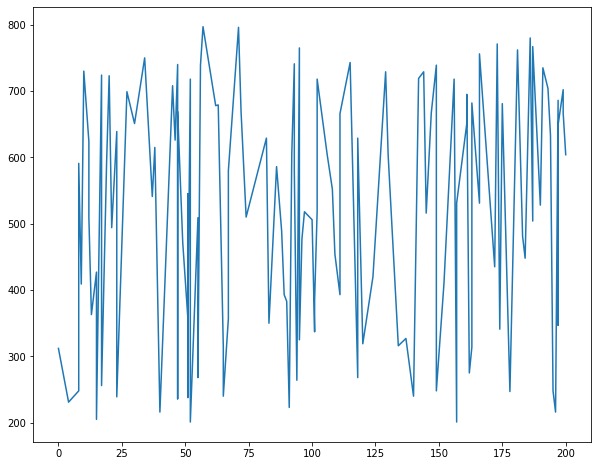

In [37]:
# It is good idea to copy the data before you plot because there is always some preprocessing to be done
plot_data = sat_scores.copy()

# we must sort by hrs_studied first (which is our X axis)
plot_data.sort_values(by="hrs_studied", inplace=True)

plt.figure(figsize=(10, 8))

# X axis = hrs_studied, Y axis = sat_math
plt.plot(plot_data.hrs_studied, plot_data.sat_math)
plt.show()

#### Example 2 

How do hours studied and maximum score of any of the 3 scores relate to each other.

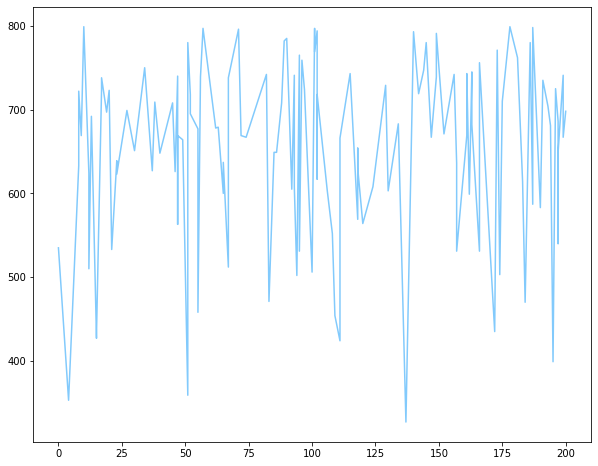

In [38]:
# It is good idea to copy the data before you plot because there is always some preprocessing to be done
plot_data = sat_scores.copy()

plot_data["max_score"] =\
    plot_data.apply(lambda row: np.max([row["sat_writing"], row["sat_verbal"], row["sat_math"]]), axis=1)

# we must sort by hrs_studied first (which is our X axis)
plot_data.sort_values(by="hrs_studied", inplace=True)

plt.figure(figsize=(10, 8))

# X axis = hrs_studied, Y axis = max_score
plt.plot(plot_data.hrs_studied, plot_data.max_score, color='xkcd:sky')
plt.show()

Studying more hours does not mean having higher scores even in your best test.

### Bar and pie charts

To draw bar and pie charts we use the methods with same names:
- https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar
- https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pie

Bar charts are also explained in detail in the ploting tutorial.

#### Example 1 

Bar chart of average writing score by teacher.

        teacher  sat_writing
0         Brown   480.352941
1         Davis   530.153846
2  Frederickson   449.307692
3         Perry   572.695652
4       Rajaram   472.800000
5      Spellman   482.722222
6          Tran   502.000000
7      Williams   488.875000


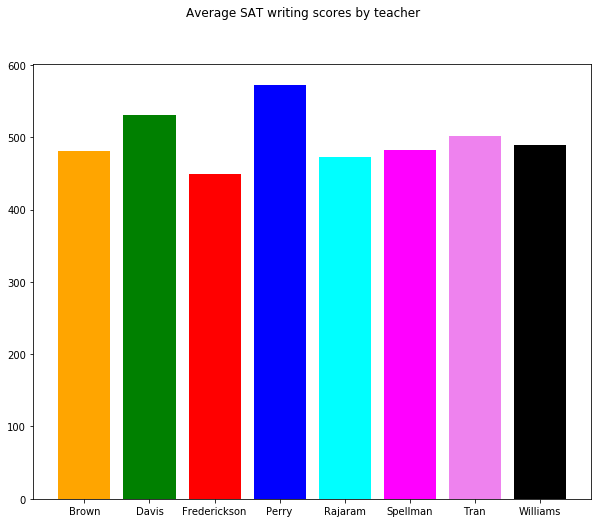

In [39]:
plot_data = sat_scores.copy()

plot_data["sat_writing"] = plot_data["sat_writing"].astype(np.float64)

plot_data = plot_data.groupby("teacher")["sat_writing"].mean().reset_index()

print(plot_data)

plt.figure(figsize=(10, 8))

plt.bar(
    x=plot_data["teacher"],
    height=plot_data["sat_writing"],
    color=["orange", "green", "red", "blue", "cyan", "magenta", "violet", "black"]
)

plt.suptitle("Average SAT writing scores by teacher")

plt.show()

#### Example 2

Sum of verbal scores by school as pie chart.

           school  sat_verbal
0  Petersville HS     26205.0
1      St. John's     25294.0
2   Washington HS     15424.0


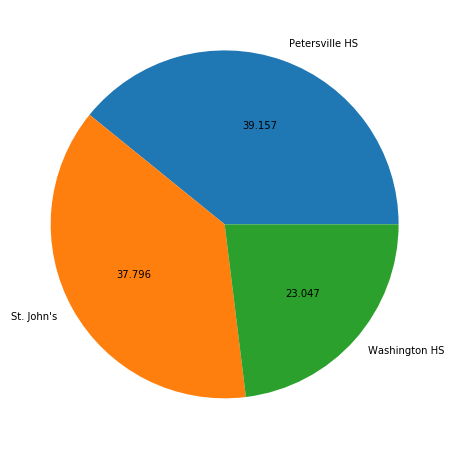

In [40]:
plot_data = sat_scores.copy()

plot_data["sat_verbal"] = plot_data["sat_verbal"].astype(np.float32)

plot_data = plot_data.groupby("school")["sat_verbal"].sum().reset_index()

print(plot_data)

# make sure that width=height so the pie does not look squashed
plt.figure(figsize=(8, 8))

plt.pie(plot_data["sat_verbal"], # data from which to get the fractions
        labels=plot_data["school"],  # labels for each pie slice (school names in this case)
        autopct="%.3f") # format string using old python formatting notation for displaying the percents

plt.show()

### Scatter plots 

- https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter

Detailed information is present in the plotting guide.

#### Example 1

We will visually test if writing and verbal scores correlate.

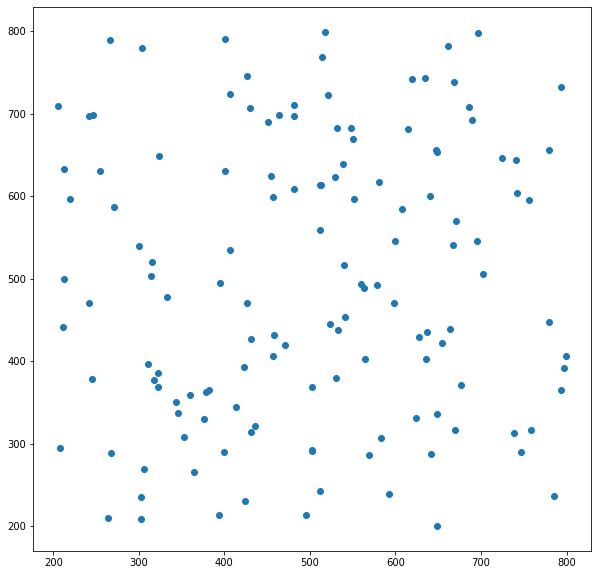

In [41]:
plot_data = sat_scores.copy()

plt.figure(figsize=(10, 10))

plt.scatter(x = plot_data["sat_writing"].astype(np.float32),
            y = plot_data["sat_verbal"].astype(np.float32))
plt.show()

And the answer is no, not at all but maybe some clusters exist.

#### Example 2

Extending our scatter plot with coloring the dots by teacher to see if we can find clusters of similar performing students.

{'Frederickson': 'orange', 'Spellman': 'green', 'Davis': 'red', 'Brown': 'blue', 'Perry': 'cyan', 'Rajaram': 'magenta', 'Williams': 'violet', 'Tran': 'black'}


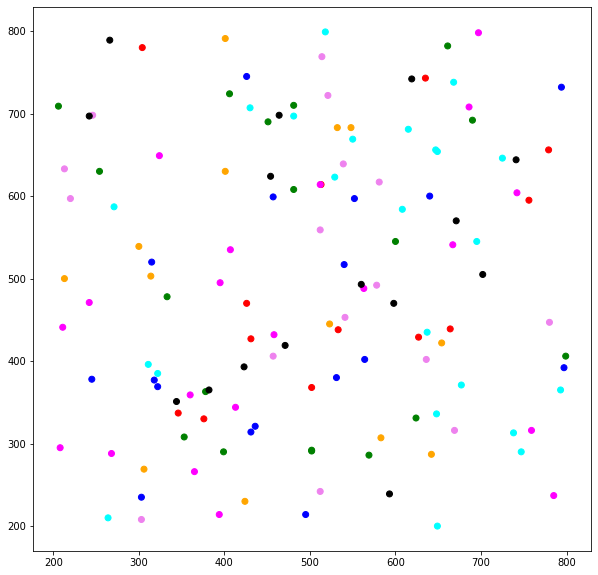

In [42]:
plot_data = sat_scores.copy()

color_dict = dict(zip(plot_data["teacher"].unique(), 
                      ["orange", "green", "red", "blue", "cyan", "magenta", "violet", "black"]))

print(color_dict)

# See map is useful in contexts outside VLOOKUP
# We use it here to give each student in sat_scores a color based on its teacher.
color_sequence = plot_data["teacher"].map(color_dict)

plt.figure(figsize=(10, 10))

plt.scatter(x = plot_data["sat_writing"].astype(np.float32),
            y = plot_data["sat_verbal"].astype(np.float32),
            c = color_sequence
           )
plt.show()

We see that small isolated clusters exist but nothing significant.

### Histogram plots

- https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist

Also see the ploting guide linked above where histograms are explained in detail.

#### Example 1 

The histogram of scores for all 3 scores.

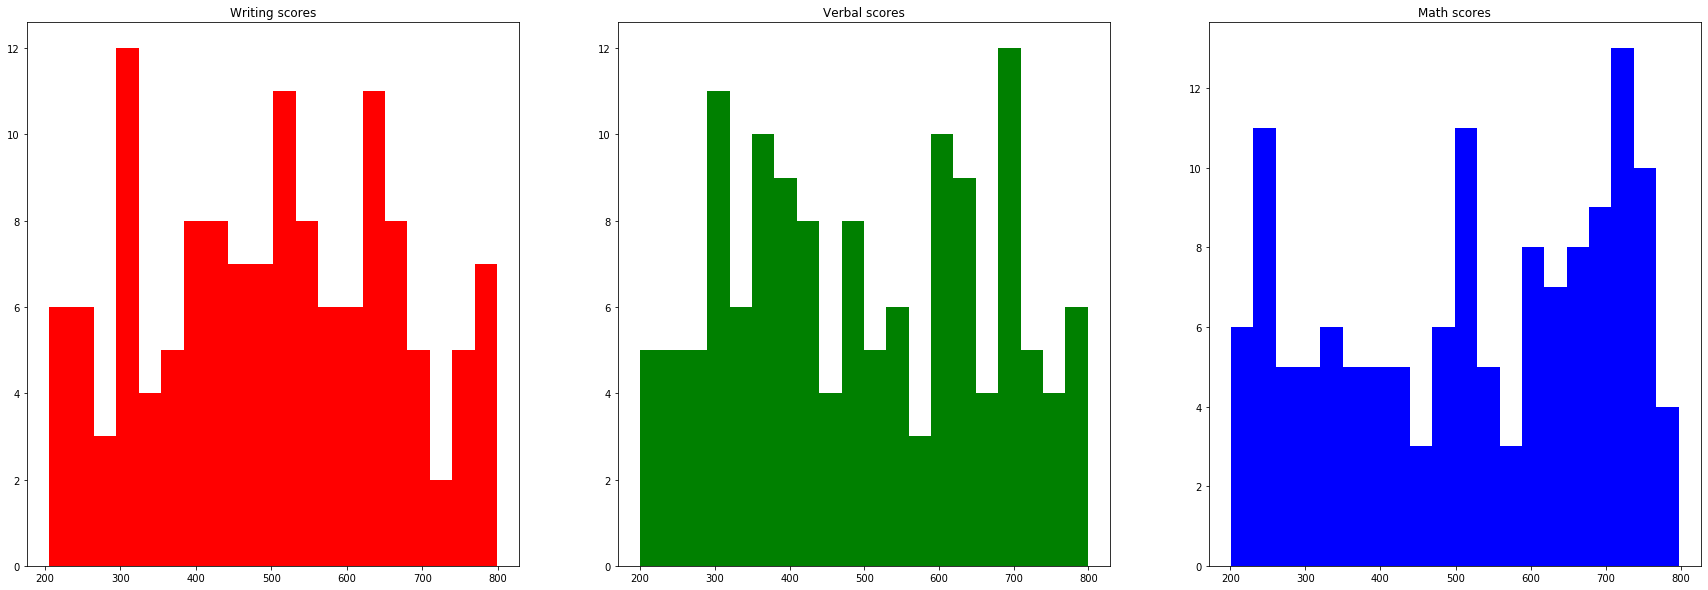

In [43]:
# https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

axes[0].set_title("Writing scores")
axes[0].hist(sat_scores["sat_writing"].astype(np.float32), bins=20, color='red')

axes[1].set_title("Verbal scores")
axes[1].hist(sat_scores["sat_verbal"].astype(np.float32), bins=20, color='green')

axes[2].set_title("Math scores")
axes[2].hist(sat_scores["sat_math"].astype(np.float32), bins=20, color='blue')

plt.show()

### Box plots

- https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot

#### Example 1

Box plot of hours studied

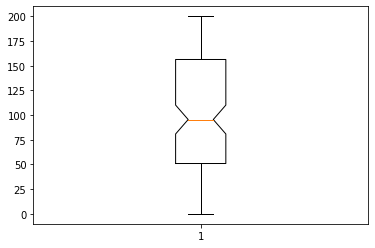

In [45]:
plot_data = sat_scores.copy()

plot_data.dropna(inplace=True)

plt.boxplot(plot_data["hrs_studied"].astype(np.float32), notch=True)
plt.show()

We see the median time studied is around 90 hours and that there are no outliers.